In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pyautogui as pag
import random
import time
import requests
import pickle
import re
import json
import solver
from tqdm.notebook import trange
from tqdm.notebook import tqdm

ALPHABET = "abcdefghijklmnopqrstuvwxyz"

In [2]:
def verrify_all_letters_used_in_soln(board, soln) -> bool:
    # Does this work for repeated letters?
    return all(any(letter in word for word in soln) for letter in board if letter != " ")

def print_board(board):
    n = int(np.sqrt(len(board)))
    for i in range(n):
        print(board[n*i:n*(i+1)])

def get_word_list(four_letter_min=True) -> list[str]:
    words = []
    with open("words.txt", "r") as f:
        words = [line.strip() for line in f.readlines() if not four_letter_min or len(line.strip()) >= 4]
    return words

def get_word_freq_dict(four_letter_min=True, normalize=True) -> dict[str, float]:
    freqs = {}
    with open("freqs.pkl", "rb") as f:
        freqs = {k: v for k,v in pickle.load(f).items() if not four_letter_min or len(k) >=4}
    if normalize:
        freq_sum = sum(freqs.values())
        return {k: v / freq_sum for k, v in freqs.items()}
    return freqs

def get_unweighted_letter_freq_dict(four_letter_word_min=True) -> dict[str, float]:
    all_words = "".join(get_word_list(four_letter_word_min))
    return {c: all_words.count(c)/len(all_words) for c in ALPHABET}

def get_weighted_letter_freq_dict(four_letter_word_min=True) -> dict[str, float]:
    word_freqs = get_word_freq_dict(four_letter_min=four_letter_word_min)
    letter_freqs = {letter: sum(freq*word.count(letter) for word, freq in word_freqs.items() if letter in word) for letter in ALPHABET}
    return {k: v / sum(letter_freqs.values()) for k, v in letter_freqs.items()}

def plot_letter_freq_comparisons():
    # Get different frequency dicts
    unweighted_letter_freqs_all = get_unweighted_letter_freq_dict(False)
    unweighted_letter_freqs_4plus = get_unweighted_letter_freq_dict()
    weighted_letter_freqs_all = get_weighted_letter_freq_dict(False)
    weighted_letter_freqs_4plus = get_weighted_letter_freq_dict()

    # Plot bar charts
    plt.bar(range(26), [unweighted_letter_freqs_all[c] for c in ALPHABET], alpha=0.25, label="Unweighted (all)")
    plt.bar(range(26), [unweighted_letter_freqs_4plus[c] for c in ALPHABET], alpha=0.25, label="Unweighted (>3)")
    plt.bar(range(26), [weighted_letter_freqs_all[c] for c in ALPHABET], alpha=0.25, label="Weighted (all)")
    plt.bar(range(26), [weighted_letter_freqs_4plus[c] for c in ALPHABET], alpha=0.25, label="Weighted (>3)")
    plt.xticks(range(26), list(ALPHABET))
    plt.xlabel("Letter")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [4]:
letter_freq_dict = get_weighted_letter_freq_dict()
letter_freq_list = [letter_freq_dict[c] for c in ALPHABET]
word_freqs = get_word_freq_dict()

In [27]:
class Solution:
    LOW_FREQ_THRESHOLD = 5e-6
    def __init__(self, grid_str, soln=None):
        self.grid_str = grid_str

        # Get solution
        if soln:
            self.all_words = soln
        else:
            self.all_words = solver.solve(grid_str)

        if self.all_words == []:
            self.all_words = [""]
            
        # Separate required/bonus words by word frequency
        self.required_words = [word for word in self.all_words if word_freqs[word] > self.LOW_FREQ_THRESHOLD]
        self.bonus_words = [word for word in self.all_words if not word in self.required_words]
        self.num_all_words = len(self.all_words)
        self.num_required_words = len(self.required_words)
        self.num_bonus_words = len(self.bonus_words)

        # Get word lengths
        self.required_word_lengths = [len(word) for word in self.required_words]
        self.bonus_word_lengths = [len(word) for word in self.bonus_words]
        self.max_word_length = max(self.required_word_lengths)

        # Get word frequencies
        self.required_word_freqs = [word_freqs[word] for word in self.required_words]
        self.bonus_word_freqs = [word_freqs[word] for word in self.bonus_words]
        self.min_required_word_freq = min(self.required_word_freqs)
        self.max_required_word_freq = max(self.required_word_freqs)
        self.avg_required_word_freq = np.mean(self.required_word_freqs)


In [15]:
def generate_trial_board(n):
    return "".join(random.choices(ALPHABET, weights=letter_freq_list, k=n**2))

def generate_puzzle(
        n, 
        min_longest_word_len=None,
        min_word_count=None,
        min_word_freq=None,
        enforce_all_letters_used=True, 
        holes=None):
    while True:
        # Get a random board
        board = generate_trial_board(n)
        
        # Make any holes
        if holes:
            for h in holes:
                board = board[:h] + " " + board[h+1:]

        # Get solution
        soln = solver.solve(board)
        
        # Check all letters used
        if enforce_all_letters_used and not verrify_all_letters_used_in_soln(board, soln):
            continue
        
        # check word count
        if min_word_count and len(soln) < min_word_count:
            continue

        # check min word frequency
        if min_word_freq and any(word_freqs[word] < min_word_freq for word in soln):
            continue

        # Check longest word length
        if min_longest_word_len and max(len(word) for word in soln) < min_longest_word_len:
            continue

        return board, soln

In [23]:
soln = Solution("tecssneirrsnidye")
soln.num_required_words

31

In [17]:
board, soln = generate_puzzle(4)

tecs
snei
rrsn
idye

Total words: 110
Mean word frequency: 0.000078
Required words: 31
Bonus words: 79
Mean high-frequency word frequency: 0.000078
['scene', 'cents', 'scenery', 'cent', 'sees', 'reins', 'niece', 'resins', 'rent', 'tense', 'teens', 'steer', 'recent', 'teen', 'senses', 'resin', 'dire', 'sine', 'tens', 'scenes', 'seine', 'sins', 'rents', 'nice', 'sent', 'dyes', 'scent', 'nest', 'seen', 'nets', 'sense']


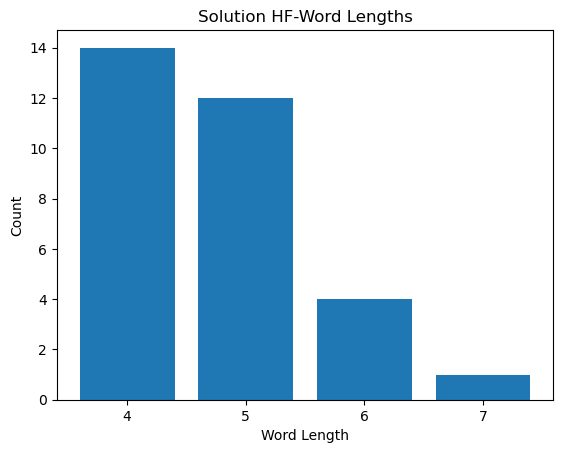

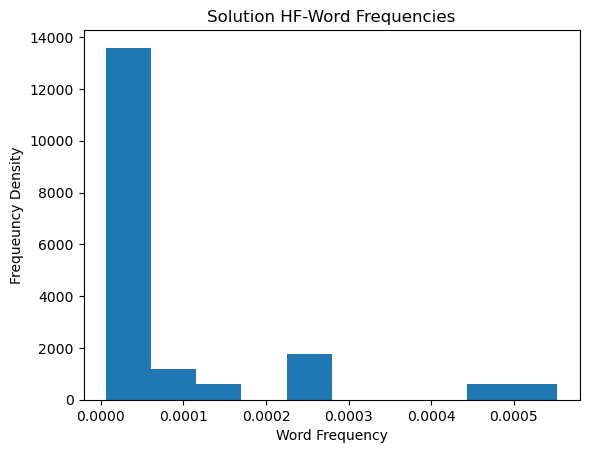

In [19]:
solution = Solution(board, soln)

print_board(board)
print(f"\nTotal words: {solution.num_all_words}")
print(f"Mean word frequency: {solution.avg_required_word_freq:.6f}")

print(f"Required words: {solution.num_required_words}")
print(f"Bonus words: {solution.num_bonus_words}")
print(f"Mean high-frequency word frequency: {solution.avg_required_word_freq:.6f}")

print(solution.required_words)

# plt.bar(range(4, max_word_len+1), [soln_word_lens.count(i) for i in range(4, max_word_len+1)])
# plt.xticks(range(4, max_word_len+1))
# plt.xlabel("Word Length")
# plt.ylabel("Count")
# plt.title("Solution Word Lengths")
# plt.show()

# plt.hist(soln_word_freqs, density=True)
# plt.xlabel("Word Frequency")
# plt.ylabel("Frequeuncy Density")
# plt.title("Solution Word Frequencies")
# plt.show()

plt.bar(range(4, solution.max_word_length+1), [solution.required_word_lengths.count(i) for i in range(4, solution.max_word_length+1)])
plt.xticks(range(4, solution.max_word_length+1))
plt.xlabel("Word Length")
plt.ylabel("Count")
plt.title("Solution HF-Word Lengths")
plt.show()

plt.hist(solution.required_word_freqs, density=True)
plt.xlabel("Word Frequency")
plt.ylabel("Frequeuncy Density")
plt.title("Solution HF-Word Frequencies")
plt.show()


In [20]:
solution.grid_str

'tecssneirrsnidye'

In [28]:
n = 4
low_freq_cutoff = 5e-6
# best_max_word_len = 0
# best_avg_word_freq = 0
# best_word_freq_sum = 0
# best_max_word_len_board = ""
# best_avg_word_freq_board = ""
# puzzles = []
while True:
    board, soln = generate_puzzle(n)
    solution = Solution(board, soln)
    puzzles.append((board, soln))

    print_latest_board = False
    if sum(solution.required_word_freqs) > best_word_freq_sum:
        best_word_freq_sum = sum(solution.required_word_freqs)
        best_word_freq_sum_board = board
        print_latest_board = True

    # if solution.max_word_length > best_max_word_len:
    #     best_max_word_len = solution.max_word_length
    #     best_max_word_len_board = board
    #     print_latest_board = True

    # if solution.avg_required_word_freq > best_avg_word_freq:
    #     best_avg_word_freq = solution.avg_required_word_freq
    #     best_avg_word_freq_board = board
    #     print_latest_board = True
    
    if print_latest_board:
        print(f"{board}")
        print(f"\t Required words: {solution.num_required_words}")
        print(f"\t Bonus words:    {solution.num_bonus_words}")
        print(f"\t Max word len:   {solution.max_word_length}")
        print(f"\t Avg word freq:  {solution.avg_required_word_freq:.6f}")
        print(f"\t Word freq sum:  {sum(solution.required_word_freqs):.6f}")

ValueError: max() iterable argument is empty

In [10]:
print_board(best_avg_word_freq_board )

oate
odih
oiuw
crcc


['coir',
 'circuit',
 'whid',
 'iodate',
 'croci',
 'rood',
 'dita',
 'croc',
 'whit',
 'teiid',
 'duroc',
 'duci',
 'diet',
 'oath',
 'withe',
 'doat',
 'width',
 'wite',
 'duro',
 'oidia',
 'huic',
 'door',
 'coda',
 'thud',
 'crud',
 'curio',
 'odor',
 'duit',
 'odic',
 'white',
 'with',
 'dite',
 'whet',
 'adit',
 'date',
 'uric']